# Boreal Forest Height Part.5
Comparing recent to predicted trends of tree canopy height changes <br>
divided by boreal vs transitional subdomains

last updated 9/7/2023

In [1]:
import os
import glob
import pandas as pd
import numpy as np

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from plotnine import *

In [2]:
hb_joined = gpd.read_file('/panfs/ccds02/nobackup/people/mfrost2/projects/boreal_hcan/data/hydrobasins_L08_patterns_tte_boreal_tundra_joined_future_recent.gpkg')

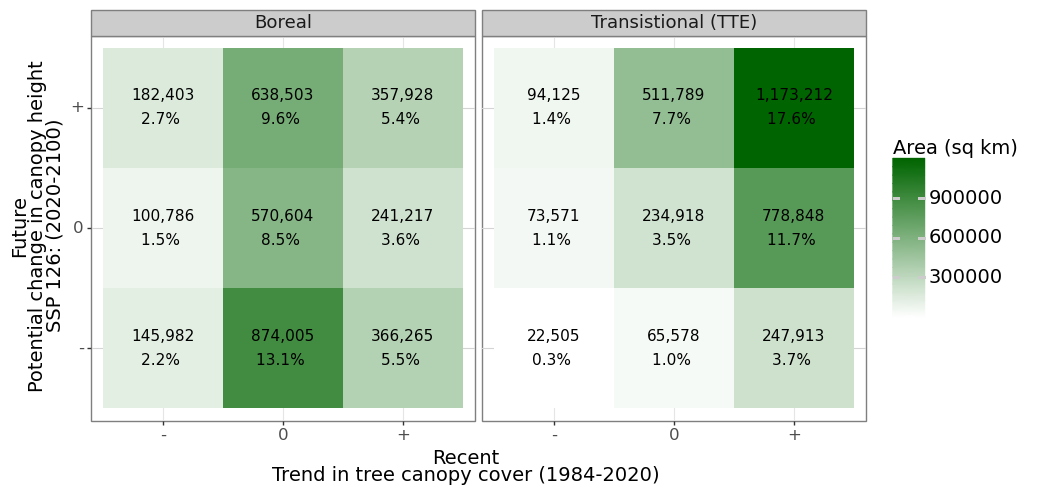

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5 in image.
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /panfs/ccds02/nobackup/people/mfrost2/projects/boreal_hcan/images/Recent_Future_Trends_126.png


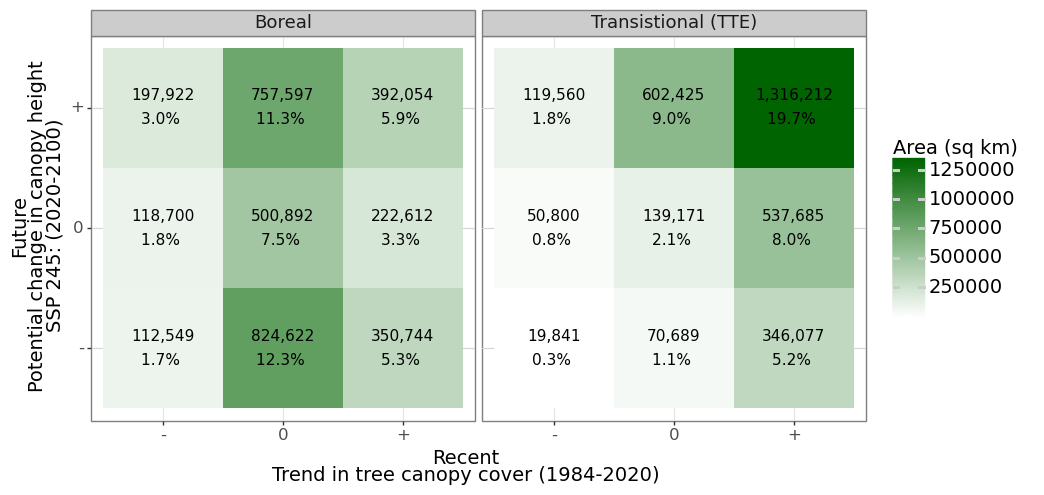

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5 in image.
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /panfs/ccds02/nobackup/people/mfrost2/projects/boreal_hcan/images/Recent_Future_Trends_245.png


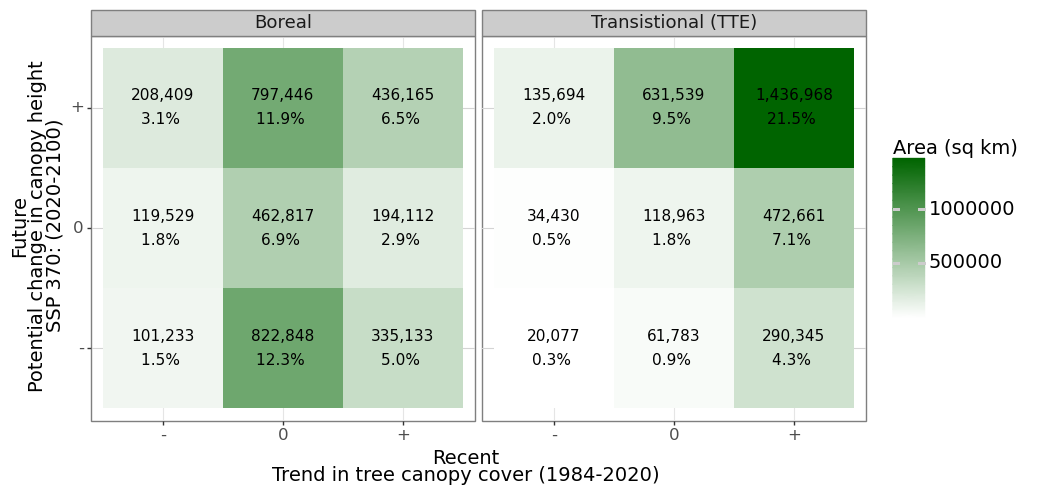

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5 in image.
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /panfs/ccds02/nobackup/people/mfrost2/projects/boreal_hcan/images/Recent_Future_Trends_370.png


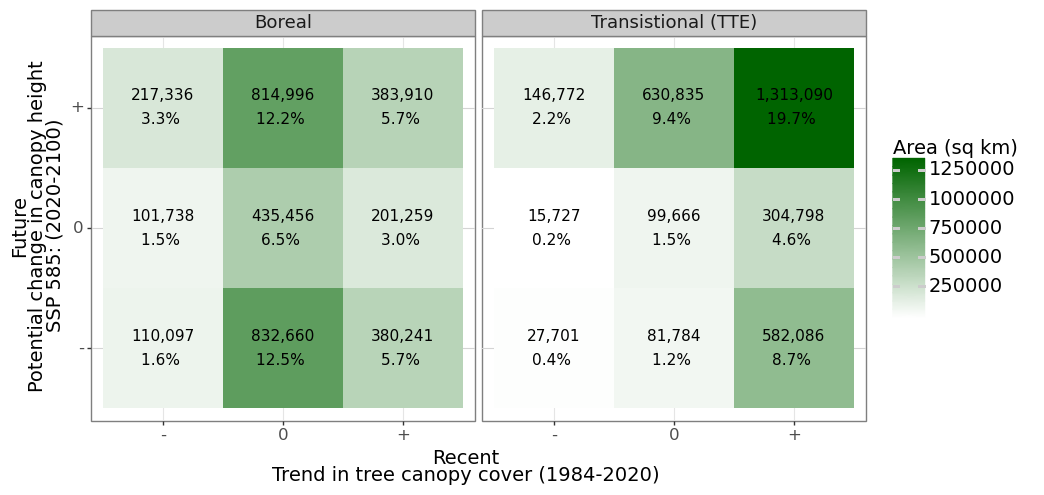

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5 in image.
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /panfs/ccds02/nobackup/people/mfrost2/projects/boreal_hcan/images/Recent_Future_Trends_585.png


In [17]:
## Looping over SSPs for the 18-square geom-tile plot to look at recent vs predicted trends
ssps = ['126', '245', '370', '585']
recent_thresh = 0.025
pred_thresh = 0.75

for ssp in ssps:
    # Get data & classify into + 0 or -
    column = str('Med_diff_ssp'+ssp+'_2081.2100')
    hb_joined_sm = hb_joined[['HYBAS_ID', 'pattern_class', 'val_terrapulse_tcc_slope_median', column, 'geometry', 'area_sqkm']].copy()
    hb_joined_sm['TTE_Boreal'] = np.where(hb_joined_sm['pattern_class'] == 'Boreal Forest (taiga)','Boreal', 'Transitional (TTE)')
    hb_joined_sm['Recent'] = np.where(hb_joined_sm['val_terrapulse_tcc_slope_median'] > recent_thresh, "+", 
                                      np.where(hb_joined_sm['val_terrapulse_tcc_slope_median'] < -(recent_thresh), "-", "0"))  
    hb_joined_sm['Prediction'] = np.where(hb_joined_sm[column] > pred_thresh, "+", 
                                      np.where(hb_joined_sm[column] < -(pred_thresh), "-", "0"))
    
    # Reformat for area
    group_area = hb_joined_sm.groupby(by=['TTE_Boreal','Recent','Prediction'])['area_sqkm'].sum().reset_index()

    ## If percent wanted
    group_area['area_sqkm_pct'] = np.where(group_area['TTE_Boreal'] == 'Boreal', 
                                     (group_area['area_sqkm']/hb_joined_sm['area_sqkm'].sum()), 
                                     (group_area['area_sqkm']/hb_joined_sm['area_sqkm'].sum()))
    group_area[['Recent', 'Prediction']] = group_area[['Recent', 'Prediction']].astype("category")
    group_area['Recent'] = group_area['Recent'].cat.reorder_categories(['-', '0', '+'])
    group_area['Prediction'] = group_area['Prediction'].cat.reorder_categories(['-', '0', '+'])
    #print(group_area)
    
    # Plot
    p = (
    ggplot(group_area)  
    + aes(x = "Recent", y = "Prediction", fill = 'area_sqkm')#, alpha = "ssp")
    + geom_tile()
    + facet_wrap("~TTE_Boreal",  ncol=2)
    + geom_text(aes(label = 'area_sqkm'), format_string='{:,.0f}', nudge_y = .1)
    + geom_text(aes(label = 'area_sqkm_pct*100'), format_string='{:.1f}% ', nudge_y = -.1)
    + labs(#title = "",
           x = "Recent\nTrend in tree canopy cover (1984-2020)",
           y = f"Future\nPotential change in canopy height\nSSP {ssp}: (2020-2100)",
           fill = "Area (sq km)")
    + theme_bw()
    + scale_fill_gradient(low="white",high="darkgreen")
    + theme(axis_text_x=element_text(angle = 0, size = 12),
            axis_text_y=element_text(size = 12),
            axis_title=element_text(size = 14),
            legend_title = element_text(size = 14),
            legend_text = element_text(size = 14),
            panel_background=element_rect(fill="white", alpha=.3),
            panel_grid_major_y=element_line(color = "#d4d4d4"),
            panel_grid_minor_y=element_line(color = "#F0F0F0"),
            #plot_title = element_text(hjust = 0.5),
            strip_text_x = element_text(size = 13),
            figure_size = (10, 5))

    )
    print(p)
    p.save(f'/panfs/ccds02/nobackup/people/mfrost2/projects/boreal_hcan/images/Recent_Future_Trends_{ssp}.png', dpi=600)

In [4]:
hb_joined_sm.head()
len(hb_joined_sm)

12422

In [5]:
# Number of hydrobasins by subdomain
group2 = hb_joined_sm.groupby(by=['TTE_Boreal'])['HYBAS_ID'].count().reset_index()
group2

,TTE_Boreal,HYBAS_ID
0,Boreal,6559
1,Transistional (TTE),5863


In [6]:
hb_joined_sm['area_sqkm'].sum()

6680152.560687749

In [7]:
group_area2 = hb_joined_sm.groupby(by=['TTE_Boreal'])['area_sqkm'].sum().reset_index()
group_area2
#3.477693e+06/3.202459e+06

,TTE_Boreal,area_sqkm
0,Boreal,3.477693e+06
1,Transistional (TTE),3.202459e+06


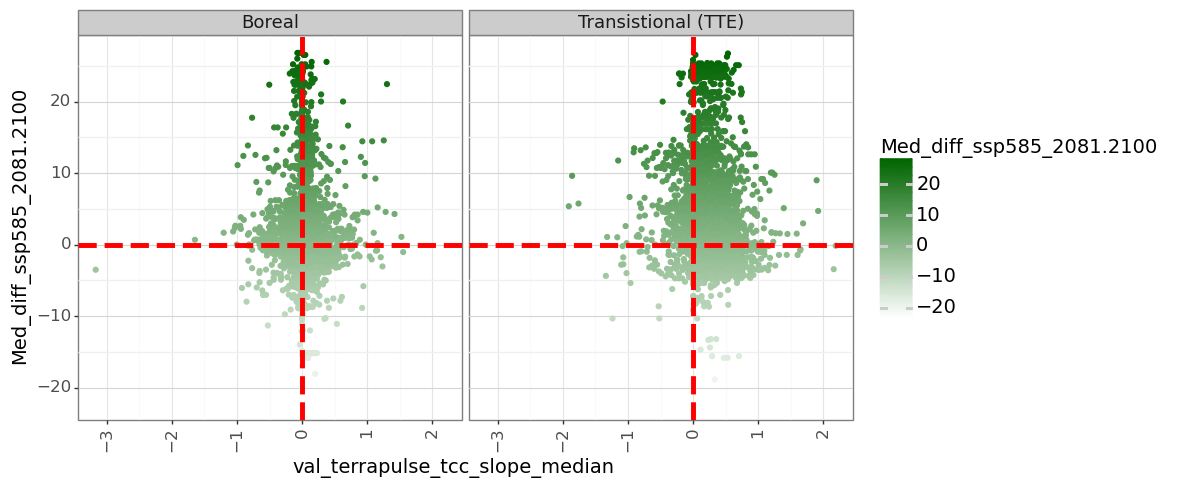

<ggplot: (1452859661587)>

In [8]:
(
    ggplot(hb_joined_sm)  
    + aes(x = "val_terrapulse_tcc_slope_median", 
          y = "Med_diff_ssp585_2081.2100", 
          fill = "Med_diff_ssp585_2081.2100", 
          color = "Med_diff_ssp585_2081.2100")#, alpha = "ssp")
    + geom_point(shape = "o")
    + facet_wrap("~TTE_Boreal",  ncol=2)
#    + geom_label(aes(label = 'HYBAS_ID_pct'), format_string='{:.2f}% ')
#     + labs(#title = "Boreal Canopy Height Difference from Current\n by Ecotone Class, Year Group, and CMIP6 SSP",
#            x = "Future Time-Period",
#            y = "Predicted Canopy Height\n Change from Current (m)",
#            #fill = "Ecotone",
#            alpha = "SSP")
#     + scale_alpha_ordinal(labels=('SSP126', 'SSP245', 'SSP370', 'SSP585'))
    + theme_bw()
    + scale_fill_gradient(low="white",high="darkgreen")
    + scale_color_gradient(low="white",high="darkgreen")
    + theme(axis_text_x=element_text(angle = 90, size = 12),
            axis_text_y=element_text(size = 12),
            axis_title=element_text(size = 14),
            legend_title = element_text(size = 14),
            legend_text = element_text(size = 14),
            panel_background=element_rect(fill="white", alpha=.3),
            panel_grid_major_y=element_line(color = "#d4d4d4"),
            panel_grid_minor_y=element_line(color = "#F0F0F0"),
            #plot_title = element_text(hjust = 0.5),
            strip_text_x = element_text(size = 13),
            figure_size = (10, 5))
    + geom_hline(yintercept=0, linetype="dashed", 
                color = "red", size=2)
    + geom_vline(xintercept=0, linetype="dashed", 
                color = "red", size=2)
)

In [15]:
hb_joined_sm['Recent_normalized'] = (hb_joined_sm['val_terrapulse_tcc_slope_median'] / (hb_joined_sm['val_terrapulse_tcc_slope_median'].max()-hb_joined_sm['val_terrapulse_tcc_slope_median'].min()))
hb_joined_sm['Prediction_normalized'] = (hb_joined_sm['Med_diff_ssp585_2081.2100'] / (hb_joined_sm['Med_diff_ssp585_2081.2100'].max()-hb_joined_sm['Med_diff_ssp585_2081.2100'].min()))
hb_test = hb_joined_sm.sort_values('area_sqkm', ascending = False)
np.median(hb_test['area_sqkm'])

360.69924352902865

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


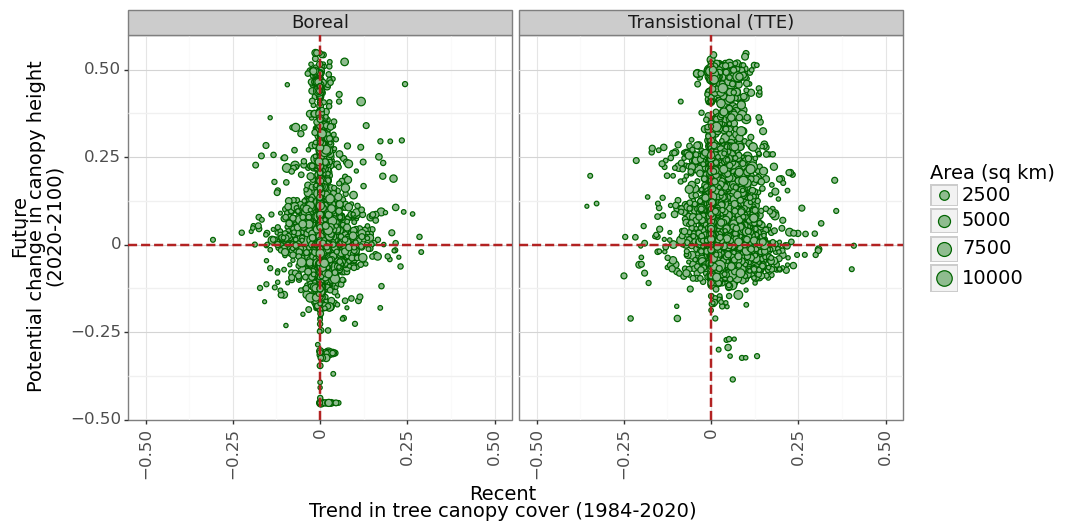

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5 in image.
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /panfs/ccds02/nobackup/people/mfrost2/projects/boreal_hcan/images/Recent_Future_Trends_Scatterplot
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


In [ ]:
p = (
    ggplot(hb_joined_sm)  
    + aes(x = 'Recent_normalized', 
          y = 'Prediction_normalized',
          size = "area_sqkm")
    + geom_point(shape = "o", color = "darkgreen", fill = "darkseagreen")
    + facet_wrap("~TTE_Boreal",  ncol=2)
    + labs(#title = "Boreal Canopy Height Difference from Current\n by Ecotone Class, Year Group, and CMIP6 SSP",
           x = "Recent\nTrend in tree canopy cover (1984-2020)",
           y = "Future\nPotential change in canopy height\n(2020-2100)",
           size = "Area (sq km)")
    + scale_x_continuous(limits=(-0.5, 0.5))
    + theme_bw()
    + theme(axis_text_x=element_text(angle = 90, size = 12),
            axis_text_y=element_text(size = 12),
            axis_title=element_text(size = 14),
            legend_title = element_text(size = 14),
            legend_text = element_text(size = 14),
            panel_background=element_rect(fill="white", alpha=.3),
            panel_grid_major_y=element_line(color = "#d4d4d4"),
            panel_grid_minor_y=element_line(color = "#F0F0F0"),
            strip_text_x = element_text(size = 13),
            figure_size = (10, 5))
    + geom_hline(yintercept=0, linetype="dashed", 
                color = "firebrick", size=1)
    + geom_vline(xintercept=0, linetype="dashed", 
                color = "firebrick", size=1)
)
print(p)
p.save('/panfs/ccds02/nobackup/people/mfrost2/projects/boreal_hcan/images/Recent_Future_Trends_Scatterplot', dpi=600)